# Preparation of the Data


To visualize the embedding it is necessary to reduce the dimension of 1536 to only 2 dimension.


### Load library's


In [257]:
import numpy as np
import postgres
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib
import random

### Define data structure


In [307]:
class DataPoint:
    def __init__(self, id:int, name:str, page:int, category, vector:np.array):
        self.id = id
        self.name = name
        self.page = page
        self.category = category
        self.vector = vector
        self.x = 0
        self.y = 0
    
    def __str__(self):
        return f"Name: {self.name}\tPage: {self.page}\nCategory: {self.category}\tVector: {self.vector[0:40]}..."
    
class Course:
    def __init__(self, name, x, y, size):
        self.name = name
        self.x = x
        self.y = y
        self.size = size
    
    def __str__(self):
        return f"Name: {self.name}\tX: {self.x}\tY: {self.y}\tSize: {self.size}"

### Loading Data from Database


In [259]:
pg = postgres.PostgresDB()
pg.connect()
response = pg.selectQuery(f"""
                SELECT doc_id, filename, path, doc_segment, embedding_ada002 as vector
                FROM embedding
                JOIN document ON id = doc_id
                --LIMIT 5;""")
pg.disconnect()

In [260]:
data = []

for element in response:
    vector = np.fromstring(element[4][1:-1], dtype=float, sep=',')
    category = element[2].split('/')[1]
    data.append(DataPoint(element[0], element[1], element[3], category, vector))

First 3 entries in `data`:


In [261]:
for i in range(3):
    print(data[i], "\n")

Name: Web AlleFolien.pdf	Page: 722
Category: Webentwicklung	Vector: [ 0.00242375  0.01570454  0.0142606  -0.01347675 -0.02080645  0.03039145
 -0.01944502  0.00889741  0.0060611  -0.03737735  0.0196238   0.01782231
  0.01045136 -0.0200226  -0.00880802  0.01237661  0.02383184 -0.01571829
  0.01552577 -0.0088699   0.00645303  0.00048131  0.01197781  0.00399146
 -0.02418939  0.01663966  0.01738226 -0.01798734 -0.00268332 -0.02934631
  0.02715978 -0.006704   -0.04529838 -0.01684594 -0.01578705  0.00981878
 -0.00335544 -0.00423555  0.00450027  0.02065518]... 

Name: Web AlleFolien.pdf	Page: 725
Category: Webentwicklung	Vector: [ 0.00627456  0.00993361  0.01295048 -0.03952036 -0.02667692  0.00713079
 -0.01030821 -0.01954613 -0.00669264 -0.04546046  0.0069368  -0.00929812
 -0.00873622 -0.02559325 -0.00187133  0.01410104  0.02986102 -0.01353245
  0.01304413  0.01759285 -0.01392712  0.0195595   0.00865595 -0.01204073
 -0.02921885  0.01811462  0.02397444 -0.0063147   0.00214894 -0.0379952
  0.033

In [262]:
matrix = []

for dataPoint in data:
    matrix.append(dataPoint.vector)

matrix = np.array(matrix)

### Reduce Dimensions


In [263]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(10934, 2)

### Visualize Data in a 2D-Plot


Create a list of all courses:


In [268]:
categories = []

for dataPoint in data:
    if categories.count(dataPoint.category) == 0:
        categories.append(dataPoint.category)

Prepare data for visualization:


In [294]:
colormap = plt.get_cmap('jet')

colorDict = {}  # Create an empty dictionary

for i, category in enumerate(categories):
    colorDict[category] = colormap(i / len(categories))

for i, dataPoint in enumerate(data):
    dataPoint.x = vis_dims[i][0]
    dataPoint.y = vis_dims[i][1]

Plot all data points:


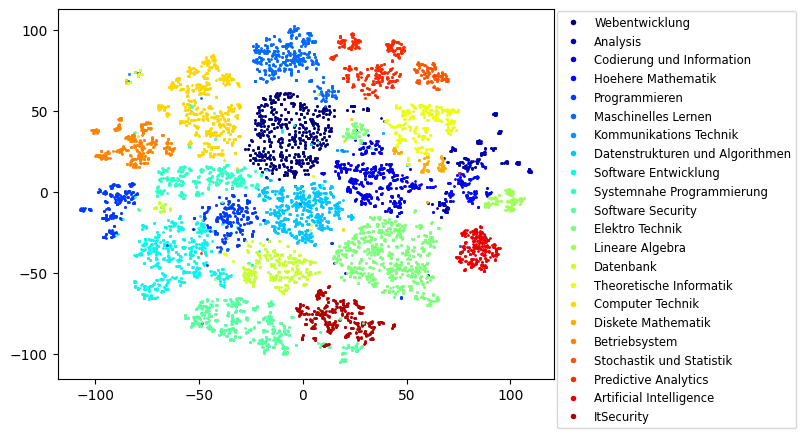

In [295]:
#for i in range(len(data)):#
#    color = colorDict.get(data[i].category)
#    plt.scatter(data[i].x, data[i].y, s=1, color=color, label=data[i].category)
#
#handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=5, markerfacecolor=color) for color in colorDict.values()]
#labels = colorDict.keys()
#plt.legend(handles, labels, loc='upper right', fontsize='small', bbox_to_anchor=(1.5, 1.01))
#
#plt.savefig('plot.svg', format='svg', dpi=1200)
#plt.savefig('plot.png', format='png', dpi=1200)

In [306]:
courses = []

for dataPoint in data:
    isExisting = False

    for course in courses:
        if dataPoint.category == course.name:
            course.x.append(dataPoint.x)
            course.x.append(dataPoint.x)
            course.size += 1
            isExisting = True

    if not isExisting:
        courses.append(Course(dataPoint.category, [dataPoint.x], [dataPoint.y], 1))

for course in courses:
    course.x = np.array(course.x).mean()
    course.y = np.array(course.y).mean()

Name: Webentwicklung	X: -5.410460948944092	Y: 17.36886215209961	Size: 914...


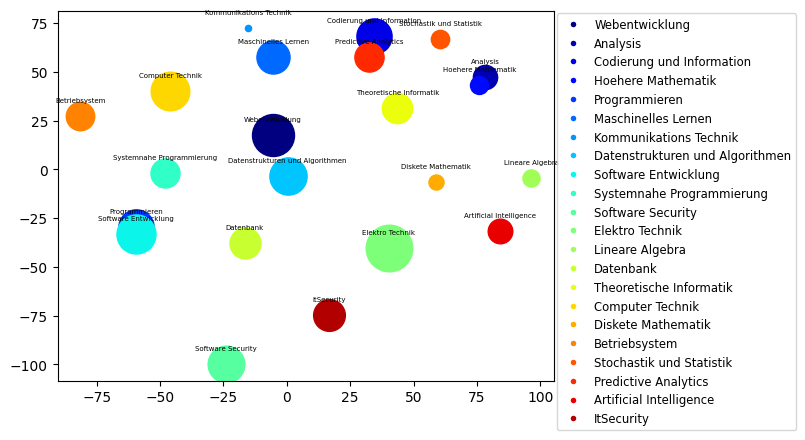

In [323]:
for i in range(len(courses)):
    color = colorDict.get(courses[i].name)
    plt.scatter(courses[i].x, courses[i].y, s=courses[i].size/1, color=color, label=courses[i].name)
    plt.annotate(courses[i].name, (courses[i].x, courses[i].y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=5)

handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=5, markerfacecolor=color) for color in colorDict.values()]
labels = colorDict.keys()
plt.legend(handles, labels, loc='upper right', fontsize='small', bbox_to_anchor=(1.5, 1.01))

plt.savefig('plot.svg', format='svg', dpi=1200)
plt.savefig('plot.png', format='png', dpi=1200)

### Export to csv


In [324]:
#All Courses
file_name = "allCourses.txt"

with open(file_name, 'w') as file:
    for course in courses:
        file.write(f"{course.name};{course.x};{course.y};{course.size}\n")

file_name = "allPages.txt"

with open(file_name, 'w') as file:
    for dataPoint in data:
        file.write(f"{dataPoint.name};{dataPoint.page};{dataPoint.category};{dataPoint.x};{dataPoint.y}\n")